In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate, configure_plot_style, AIBM_COLORS

configure_plot_style()

# Literacy

From the WEF report (emphasis added):

> Literacy rate, %
>
>Percentage of the adult population (women and men over 15 years of age) with the ability to
both read and write and make simple arithmetic calculations. *For advanced economies for which
data was unavailable in the last 10 years, the authors assumed based on older data that the
gender gap on literacy rate is closed.* 
>
>Period: 2023 or most recent year available. Source: UNESCO, UIS.Stat education statistics
data portal; when not available, data is sourced from the UNDP Human Development Reports, most
recent data available.


UNESCO stopped tracking OECD countries a while ago (more than 10 years, it seems, based on OWID data). So the WEF gives them a pass. But in many of those countries, women now surpass men in literacy, as we can see in data from the OEDC Survey of Adult Skills (PIAAC).

## WEF data

Now let's see how these results compare to WEF.
Here's the data pulled from the PDF report.

In [3]:
from utils import code_to_wef_country

wef_country_to_code = {country: code for code, country in code_to_wef_country.items()}

In [4]:

import os
from extract_pdf_data import read_pdfs

if not os.path.exists("wef_literacy_rate.csv"):
    wef = read_pdfs('literacy')
    wef.to_csv("wef_literacy_rate.csv", index=False)

In [5]:
from utils import read_wef_file

wef = read_wef_file("wef_literacy_rate.csv").drop(columns=['diff', 'left', 'right'])
wef.index = wef['country'].map(wef_country_to_code)
wef.index.name = 'code'
wef.shape

(146, 4)

In [6]:
wef.head()

,country,page_number,score,rank
code,,,,
ALB,Albania,83,0.996,65.0
DZA,Algeria,85,0.862,119.0
AGO,Angola,87,0.755,130.0
ARG,Argentina,89,1.000,1.0
ARM,Armenia,91,0.999,58.0


In [7]:
wef.tail()

,country,page_number,score,rank
code,,,,
UZB,Uzbekistan,365,1.000,1.0
VUT,Vanuatu,367,0.984,80.0
VNM,Vietnam,369,0.978,86.0
ZMB,Zambia,371,0.926,107.0
ZWE,Zimbabwe,373,1.000,1.0


55 countries got a perfect score.

In [8]:
wef['rank'].value_counts(dropna=False).head()

rank
1.0      55
NaN       2
61.0      2
119.0     1
58.0      1
Name: count, dtype: int64

89 countries had less than a perfect score.

In [9]:
dinged = wef['score'] < 1
dinged.sum()

np.int64(89)

Here's the distribution of WEF scores.

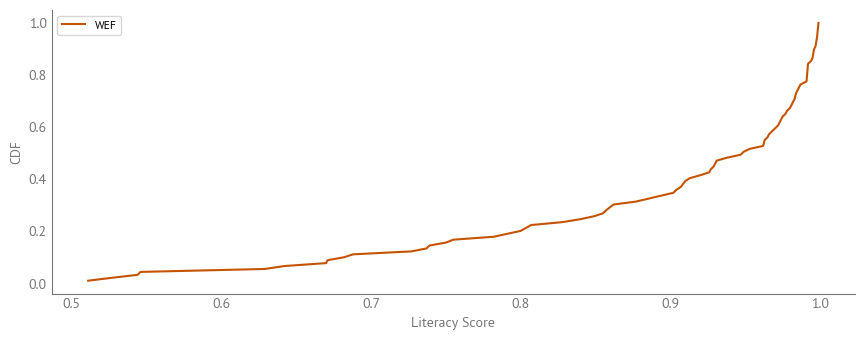

In [10]:
from empiricaldist import Cdf

cdf_score = Cdf.from_seq(wef.loc[dinged, 'score'])
cdf_score.plot(label='WEF')
decorate(xlabel='Literacy Score', ylabel='CDF')

## UNESCO Data

The WEF data includes only the scores, not the male and female percentages, so we can't compute the untruncated scores.

But since they used UNESCO data, we can go back to the source:

UNESCO, UIS.Stat Education statistics data portal. When not available, data is sourced from United Nations Development Programme, Human Development Reports, most recent year available between 2013 and 2023.

https://databrowser.uis.unesco.org/view#=countries&geoUnits=&timeMode=range&view=table&chartMode=multiple&chartHighlightSeries=&chartHighlightEnabled=true&indicatorPaths=UIS-SDG4Monitoring%3A0%3ALR.GALP.AG15T24.F%2CUIS-SDG4Monitoring%3A0%3ALR.GALP.AG15T24.M%2CUIS-SDG4Monitoring%3A0%3ALR.GALP.AG15T99.F%2CUIS-SDG4Monitoring%3A0%3ALR.GALP.AG15T99.M%2CUIS-SDG4Monitoring%3A0%3ALR.GALP.AG25T64.F%2CUIS-SDG4Monitoring%3A0%3ALR.GALP.AG25T64.M&geoMode=countries&tableIndicatorId=LR.GALP.AG15T99.F&years=2013%2C2022


In [11]:
filename = "indicator-data-export_LR.GALP.AG15T24.F_LR.GALP.AG15T24.M_LR.GALP.AG15T99.F_and_3_more/data.csv"

unesco = pd.read_csv(filename)
unesco.head()

,indicatorId,geoUnit,year,value,qualifier,magnitude
0,LR.GALP.AG15T24.F,ABW,2020,99,UIS_EST,NaN
1,LR.GALP.AG15T24.F,AGO,2022,81,UIS_EST,NaN
2,LR.GALP.AG15T24.F,ALB,2022,100,UIS_EST,NaN
3,LR.GALP.AG15T24.F,BDI,2022,93,UIS_EST,NaN
4,LR.GALP.AG15T24.F,BEN,2006,31,UIS_EST,NaN


In [12]:
from utils import code_to_wef_country

unesco['country'] = unesco['geoUnit'].map(code_to_wef_country)
unesco.head()

,indicatorId,geoUnit,year,value,qualifier,magnitude,country
0,LR.GALP.AG15T24.F,ABW,2020,99,UIS_EST,NaN,Aruba
1,LR.GALP.AG15T24.F,AGO,2022,81,UIS_EST,NaN,Angola
2,LR.GALP.AG15T24.F,ALB,2022,100,UIS_EST,NaN,Albania
3,LR.GALP.AG15T24.F,BDI,2022,93,UIS_EST,NaN,Burundi
4,LR.GALP.AG15T24.F,BEN,2006,31,UIS_EST,NaN,Benin


In [13]:
unesco['value'].isna().sum()

np.int64(0)

In [14]:
unesco['indicatorId'].unique()

array(['LR.GALP.AG15T24.F', 'LR.GALP.AG15T24.M', 'LR.GALP.AG15T99.F',
       'LR.GALP.AG15T99.M', 'LR.GALP.AG25T64.F', 'LR.GALP.AG25T64.M'],
      dtype=object)

From each group, select the row with the latest date


In [15]:
grouped = unesco.groupby(["indicatorId", "geoUnit"]).last()
grouped

year  value qualifier  magnitude    country
indicatorId       geoUnit                                             
LR.GALP.AG15T24.F ABW      2020     99   UIS_EST        NaN      Aruba
                  AGO      2022     81   UIS_EST        NaN     Angola
                  ALB      2022    100   UIS_EST        NaN    Albania
                  BDI      2022     93   UIS_EST        NaN    Burundi
                  BEN      2012     41   UIS_EST        NaN      Benin
...                         ...    ...       ...        ...        ...
LR.GALP.AG25T64.M VEN      2022     98   UIS_EST        NaN  Venezuela
                  VUT      2021     89   UIS_EST        NaN    Vanuatu
                  YEM      2004     63   UIS_EST        NaN      Yemen
                  ZMB      2020     90   UIS_EST        NaN     Zambia
                  ZWE      2022     89   UIS_EST        NaN   Zimbabwe

[606 rows x 5 columns]

In [16]:
def get_literacy_ratio(grouped, age_group):
    male = grouped.loc[f'LR.GALP.{age_group}.M']
    female = grouped.loc[f'LR.GALP.{age_group}.F']

    literacy = pd.concat([male, female], axis=1, keys=["male", "female"])
    ratio = literacy['female', 'value'] / literacy['male', 'value']
    return ratio

After some trial and error, it looks like WEF used the `AG15T99` age group.

In [17]:
unesco_ratio = get_literacy_ratio(grouped, 'AG15T99')

There are only a few countries with ratios over 1, and only one where it is substantially greater than 1. So truncation doesn't have much effect on the countries UNESCO is still tracking.

In [18]:
unesco_ratio.sort_values(ascending=False).head(11)

geoUnit
LSO    1.250000
ZWE    1.034091
MLT    1.032258
BLZ    1.012500
NIC    1.012195
BWA    1.011628
BRA    1.010638
DOM    1.010526
SYC    1.010417
VEN    1.010309
CYM    1.000000
dtype: float64

Compute the untruncated score

In [19]:
unesco_score = 1 - np.abs(unesco_ratio - 1)
unesco_score = pd.Series(unesco_score, index=unesco_ratio.index, name='unesco_score')
unesco_score.head()

geoUnit
ABW    1.000000
AGO    0.759036
ALB    0.989899
BDI    0.841463
BEN    0.488889
Name: unesco_score, dtype: float64

In [20]:
unesco_score.describe()

count    101.000000
mean       0.899816
std        0.133846
min        0.479452
25%        0.862069
50%        0.962025
75%        0.990000
max        1.000000
Name: unesco_score, dtype: float64

Compute the truncated score

In [21]:
unesco_score_truncated = np.where(unesco_ratio > 1, 1, unesco_score)
unesco_score_truncated = pd.Series(unesco_score_truncated, 
                                   index=unesco_ratio.index, 
                                   name='unesco_score_truncated')
unesco_score_truncated.head()

geoUnit
ABW    1.000000
AGO    0.759036
ALB    0.989899
BDI    0.841463
BEN    0.488889
Name: unesco_score_truncated, dtype: float64

In [22]:
unesco_score_truncated.describe()

count    101.000000
mean       0.903722
std        0.134291
min        0.479452
25%        0.862500
50%        0.968750
75%        1.000000
max        1.000000
Name: unesco_score_truncated, dtype: float64

Add the scores to WEF

In [23]:
def merge_column(wef, series, col):
    wef[col] = np.nan

    for code, score in series.items():
        if code in wef.index:
            wef.loc[code, col] = score

    missing = wef[col].isna()
    return wef.index[missing]

In [24]:
merge_column(wef, unesco_score, "unesco_score")

Index(['ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BRB', 'BLR', 'BEL', 'BOL', 'CAN',
       'CHN', 'COL', 'CZE', 'DNK', 'ECU', 'SLV', 'FJI', 'FIN', 'FRA', 'GEO',
       'DEU', 'GHA', 'GRC', 'HND', 'ISL', 'IND', 'IDN', 'IRL', 'ISR', 'ITA',
       'JAM', 'JPN', 'JOR', 'KWT', 'LBN', 'LUX', 'MYS', 'MLI', 'MEX', 'MNG',
       'MOZ', 'NLD', 'NZL', 'NER', 'NOR', 'OMN', 'PAK', 'PAN', 'PRY', 'PER',
       'PHL', 'QAT', 'ROU', 'SAU', 'SEN', 'SRB', 'SGP', 'SVK', 'ZAF', 'ESP',
       'LKA', 'SWE', 'CHE', 'TGO', 'TUN', 'TUR', 'ARE', 'GBR', 'USA', 'URY',
       'UZB', 'VNM'],
      dtype='object', name='code')

In [25]:
merge_column(wef, unesco_score_truncated, "unesco_score_truncated")

Index(['ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BRB', 'BLR', 'BEL', 'BOL', 'CAN',
       'CHN', 'COL', 'CZE', 'DNK', 'ECU', 'SLV', 'FJI', 'FIN', 'FRA', 'GEO',
       'DEU', 'GHA', 'GRC', 'HND', 'ISL', 'IND', 'IDN', 'IRL', 'ISR', 'ITA',
       'JAM', 'JPN', 'JOR', 'KWT', 'LBN', 'LUX', 'MYS', 'MLI', 'MEX', 'MNG',
       'MOZ', 'NLD', 'NZL', 'NER', 'NOR', 'OMN', 'PAK', 'PAN', 'PRY', 'PER',
       'PHL', 'QAT', 'ROU', 'SAU', 'SEN', 'SRB', 'SGP', 'SVK', 'ZAF', 'ESP',
       'LKA', 'SWE', 'CHE', 'TGO', 'TUN', 'TUR', 'ARE', 'GBR', 'USA', 'URY',
       'UZB', 'VNM'],
      dtype='object', name='code')

How different are the WEF and truncated UNESCO scores?

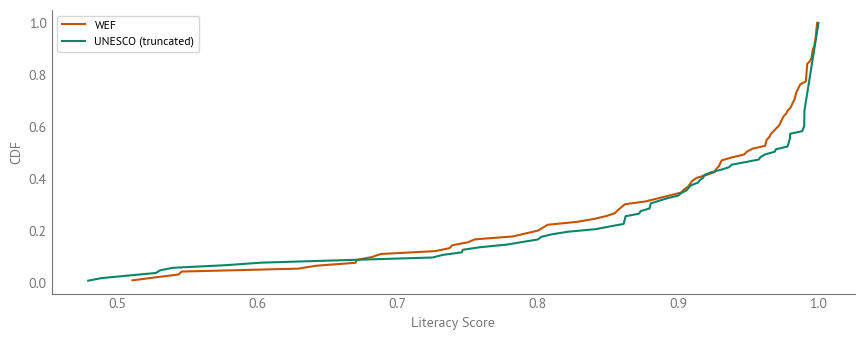

In [26]:
cdf_unesco_truncated = Cdf.from_seq(unesco_score_truncated)

cdf_score.plot(label='WEF')
cdf_unesco_truncated.plot(label='UNESCO (truncated)')
decorate(xlabel='Literacy Score', ylabel='CDF')

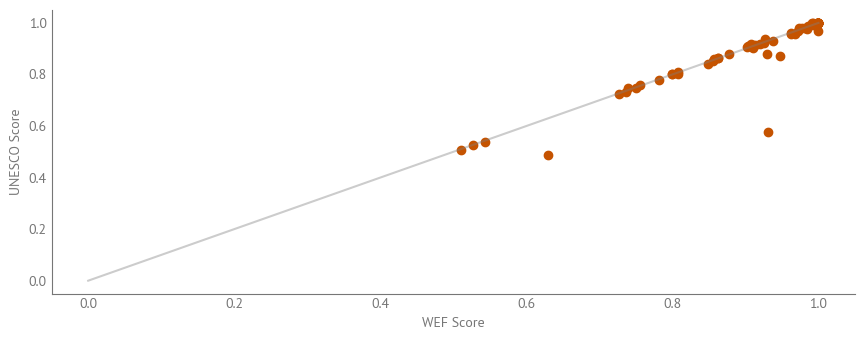

In [27]:
plt.plot([0, 1], [0, 1], color='gray', alpha=0.4)
plt.scatter(wef['score'], wef['unesco_score_truncated'])
decorate(xlabel='WEF Score', ylabel='UNESCO Score')

There are only a few countries where the difference is non-negligible.

In [28]:
diff = wef['score'] - wef['unesco_score_truncated']
diff.sort_values(key=abs, ascending=False).head()

code
CIV    0.354077
BEN    0.140111
RWA    0.073761
BGD    0.050000
MKD    0.030303
dtype: float64

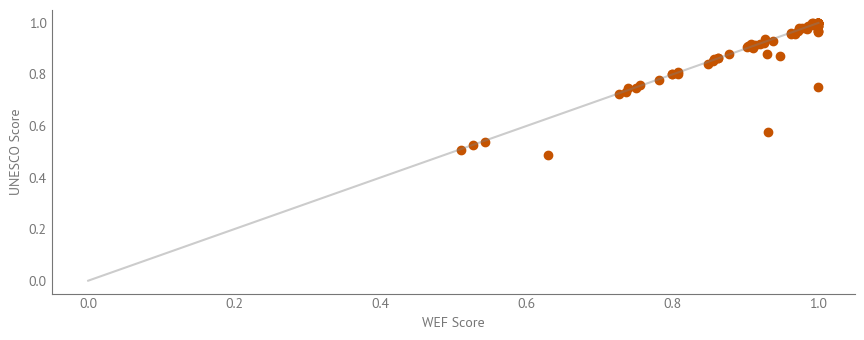

In [29]:
plt.plot([0, 1], [0, 1], color='gray', alpha=0.4)
plt.scatter(wef['score'], wef['unesco_score'])
decorate(xlabel='WEF Score', ylabel='UNESCO Score')

## Our World In Data

OWID provides a curated dataset of literacy scores, most ultimately from UNESCO.

This dataset is only young men and young women, so it is substantially different from what we see in the WEF and UNESCO dataset.

We can download the data from their API:

In [30]:
import requests

# Fetch the data.
owid_all = pd.read_csv("https://ourworldindata.org/grapher/literacy-rate-of-young-men-and-women.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Fetch the metadata
metadata = requests.get("https://ourworldindata.org/grapher/literacy-rate-of-young-men-and-women.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

KeyboardInterrupt: 

In [ ]:
metadata

In [ ]:
owid_all.columns = ['entity', 'code', 'year', 'literacy_male', 'literacy_female', 'owid_region']

In [ ]:
owid_all.head()

To get the most recent data point for each country, we can use `groupby` and `last`, then compute the ratio of female to male literacy, and the corresponding (symmetric) score.

In [ ]:
owid = owid_all.groupby(["code"]).last()
owid.shape

In [ ]:
owid['ratio'] = owid['literacy_female'] / owid['literacy_male']
owid.sort_values(by='ratio', ascending=False).head(20)

In [ ]:
owid['score'] = 1 - np.abs(owid['ratio'] - 1)

In [ ]:
owid['ratio'].describe()

In [ ]:
owid['score_truncated'] = np.where(owid['ratio'] > 1, 1, owid['score'])

In [ ]:
owid.head(20)

In [ ]:
owid['score'].describe()

In [ ]:
owid['score_truncated'].describe()

Add the OWID data to WEF

In [ ]:
merge_column(wef, owid['score'], 'owid_score')

In [ ]:
merge_column(wef, owid['score_truncated'], 'owid_score_truncated')

In [ ]:
cdf_owid_truncated = Cdf.from_seq(wef['owid_score_truncated'])

cdf_score.plot(label='WEF')
cdf_unesco_truncated.plot(label='UNESCO (truncated)')
cdf_owid_truncated.plot(label='OWID (truncated)')
decorate(xlabel='Literacy Score', ylabel='CDF')

In [ ]:
plt.plot([0, 1], [0, 1], color='gray', alpha=0.4)
plt.scatter(wef['score'], wef['owid_score_truncated'])
decorate(xlabel='WEF Score', ylabel='OWID Score')

## OECD PIAAC

From https://www.oecd.org/en/about/programmes/piaac.html

>The Programme for the International Assessment of Adult Competencies (PIAAC) is a programme of assessment and analysis of adult skills. The major product of PIAAC is the Survey of Adult Skills, an international computer-based household survey of adults aged 16-65 years. It is designed as 10-yearly cycles.

>The Survey measures adults’ proficiency in key information-processing skills - literacy, numeracy and problem solving – which represent skills needed for individuals to participate in society and for economies to prosper. It also gathers information and data on how adults use their skills at home and at work.

>The 1st Cycle of the Survey of Adult Skills was conducted over three separate rounds between 2011 and 2018 in 39 countries. During the 1st Cycle, about 245 000 adults were interviewed, representing 1.15 billion people.

>The 2nd Cycle of the Survey of Adults Skills has been conducted in 31 countries and economies so far. A first round of data collection took place in 2022-2023 with results released on 10 December 2024.  




I downloaded two tables from https://www.oecd.org/en/publications/do-adults-have-the-skills-they-need-to-thrive-in-a-changing-world_b263dc5d-en/full-report/tables-of-results-for-countries-and-economies_0432d7e4.html#annex-d1e19379-dc605a08b8:

* Table A.2.7 (L): Literacy proficiency, by gender

* Table A.2.8 (L): Literacy proficiency, by gender and age group

Both are sheets in this Excel spreadsheet: https://stat.link/eb8dxq

The first table includes "Percentage of low performers (scoring at Level 1 or below)", which we will use as a replacement for illiteracy.

Here's the description of Level 1:

> Adults at Level 1 are able to locate information on a text page, find a relevant link from a website, and identify relevant text among multiple options when the relevant information is explicitly cued. They can understand the meaning of short texts, as well as the organization of lists or multiple sections within a single page.
>
>The texts at level 1 may be continuous, noncontinuous, or mixed and pertain to printed or digital environments. They typically include a single page with up to a few hundred words and little or no distracting information. Noncontinuous texts may have a list structure (such as a web search engine results page) or include a small number of independent sections, possibly with pictorial illustrations or simple diagrams. Tasks at Level 1 involve simple questions providing some guidance as to what needs to be done and a single processing step. There is a direct, fairly obvious match between the question and target information in the text, although some tasks may require the examination of more than one piece of information.

We'll flip the sense by computing:

`literacy rate = (100 - Percentage of low performers)`

Here's the data.


In [31]:
piaac = pd.read_excel('eb8dxq.xlsx', sheet_name='A.2.7 (L)', skiprows=6, skipfooter=11)

piaac.columns = ['country', 'mean', 'se', 
           'male_mean', 'male_mean_se', 'female_mean', 'female_mean_se',
           'diff', 'diff_se', 
           'unused', 'unused', 'unused', 'unused', 
           'male_percent', 'male_percent_se', 'female_percent', 'female_percent_se', 
           'unused', 'unused']

piaac.head()

,country,mean,se,male_mean,male_mean_se,female_mean,female_mean_se,diff,diff_se,unused,unused,unused,unused,male_percent,male_percent_se,female_percent,female_percent_se,unused,unused
0,Austria,254.369808,0.880442,254.309342,1.451380,254.430673,1.187266,-0.121331,1.983984,0.951235,-2.799169,1.736435,0.106957,29.282004,1.231198,28.620819,1.125002,0.661185,1.777549
1,Canada,270.770314,0.870268,271.017313,1.437290,270.522105,1.139001,0.495207,1.923685,0.796850,0.638806,1.614895,0.692421,19.670112,1.145555,18.873108,0.983209,0.797005,1.585128
2,Chile,217.889950,2.153137,217.680876,3.046819,218.099045,1.813228,-0.418169,2.568732,0.870682,0.458546,1.766441,0.795182,53.238281,2.393751,53.549892,1.859101,-0.311611,2.405293
3,Czechia,260.205637,0.982685,259.479752,1.676722,260.958352,1.230915,-1.478599,2.199785,0.501484,0.795314,1.835662,0.664828,26.072850,1.385492,23.422168,1.051619,2.650682,1.936533
4,Denmark,273.033693,0.811874,271.499922,1.404251,274.600515,1.177973,-3.100594,2.023761,0.125499,1.055020,1.518884,0.487304,19.805036,1.053472,15.903784,0.809196,3.901252,1.441933


In [32]:
piaac_country_to_code = {
    'Austria': 'AUT',
    'Canada': 'CAN',
    'Chile': 'CHL',
    'Czechia': 'CZE',
    'Denmark': 'DNK',
    'Estonia': 'EST',
    'Finland': 'FIN',
    'France': 'FRA',
    'Germany': 'DEU',
    'Hungary': 'HUN',
    'Ireland': 'IRL',
    'Israel': 'ISR',
    'Italy': 'ITA',
    'Japan': 'JPN',
    'Korea': 'KOR',
    'Latvia': 'LVA',
    'Lithuania': 'LTU',
    'Netherlands': 'NLD',
    'New Zealand': 'NZL',
    'Norway': 'NOR',
    'Poland*': 'POL',
    'Portugal': 'PRT',
    'Slovak Republic': 'SVK',
    'Spain': 'ESP',
    'Sweden': 'SWE',
    'Switzerland': 'CHE',
    'United States': 'USA'
}



In [33]:
piaac.index = piaac['country'].map(piaac_country_to_code)
piaac.index.name = 'code'
piaac.head()

,country,mean,se,male_mean,male_mean_se,female_mean,female_mean_se,diff,diff_se,unused,unused,unused,unused,male_percent,male_percent_se,female_percent,female_percent_se,unused,unused
code,,,,,,,,,,,,,,,,,,,
AUT,Austria,254.369808,0.880442,254.309342,1.451380,254.430673,1.187266,-0.121331,1.983984,0.951235,-2.799169,1.736435,0.106957,29.282004,1.231198,28.620819,1.125002,0.661185,1.777549
CAN,Canada,270.770314,0.870268,271.017313,1.437290,270.522105,1.139001,0.495207,1.923685,0.796850,0.638806,1.614895,0.692421,19.670112,1.145555,18.873108,0.983209,0.797005,1.585128
CHL,Chile,217.889950,2.153137,217.680876,3.046819,218.099045,1.813228,-0.418169,2.568732,0.870682,0.458546,1.766441,0.795182,53.238281,2.393751,53.549892,1.859101,-0.311611,2.405293
CZE,Czechia,260.205637,0.982685,259.479752,1.676722,260.958352,1.230915,-1.478599,2.199785,0.501484,0.795314,1.835662,0.664828,26.072850,1.385492,23.422168,1.051619,2.650682,1.936533
DNK,Denmark,273.033693,0.811874,271.499922,1.404251,274.600515,1.177973,-3.100594,2.023761,0.125499,1.055020,1.518884,0.487304,19.805036,1.053472,15.903784,0.809196,3.901252,1.441933


Here's the ratio intended to be comparable to the WEF equity scores, except that it's symmetric.

In [34]:
piaac['ratio'] = (100 - piaac['female_percent']) / (100 - piaac['male_percent'])
piaac['ratio'].describe()

count    27.000000
mean      1.041883
std       0.032982
min       0.973661
25%       1.018114
50%       1.045394
75%       1.062122
max       1.099257
Name: ratio, dtype: float64

In [35]:
piaac['score'] = 1 - np.abs(piaac['ratio'] - 1)
piaac['score'].describe()

count    27.000000
mean      0.955317
std       0.028915
min       0.900743
25%       0.937878
50%       0.954606
75%       0.977354
max       0.995735
Name: score, dtype: float64

In [36]:
piaac['score_truncated'] = np.where(piaac['ratio'] > 1, 1, piaac['score'])
piaac['score_truncated'].describe()

count    27.000000
mean      0.998600
std       0.005219
min       0.973661
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: score_truncated, dtype: float64

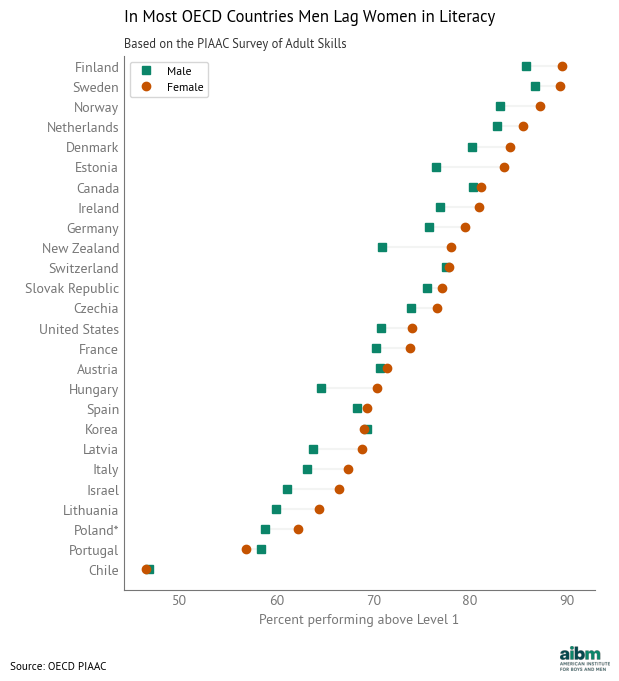

In [37]:
from utils import add_title, add_subtext, add_logo

piaac_sorted = piaac.sort_values(by='female_percent')
country = piaac_sorted['country']
male = 100 - piaac_sorted['male_percent']
female = 100 - piaac_sorted['female_percent']

fig, ax = plt.subplots(figsize=(6, 6))
plt.hlines(country, male, female, color=AIBM_COLORS['light_gray'])
plt.plot(male, country, 's', color=AIBM_COLORS['green'], label='Male')
plt.plot(female, country, 'o', color=AIBM_COLORS['orange'], label='Female')
ax.invert_yaxis()

decorate(xlabel='Percent performing above Level 1', ylim=[len(piaac), 0.5])
add_title("In Most OECD Countries Men Lag Women in Literacy",
          "Based on the PIAAC Survey of Adult Skills", y=1.01)
add_subtext("Source: OECD PIAAC", y=-0.05)
logo = add_logo(location=(1.0, -0.05))

### PIACC by age and gender

The percentages in the previous table include all adults, so they are comparable to WEF literacy percentages in that sense.
But adult literacy is a long-lagging indicator of equity in primary and secondary education. To get a sense of generational shifts, we can split the PIAAC data by age group, this time using average scores rather than percentages above or below Level 1. 

In [38]:
piaac2 = pd.read_excel('eb8dxq.xlsx', sheet_name='A.2.8 (L)', skiprows=7, skipfooter=11)
piaac2.columns = ['country', 'mean', 'se', 
              'male_1624', 'unused', 
              'male_2544', 'unused',
              'male_4565', 'unused', 
              'female_1624', 'unused', 
              'female_2544', 'unused', 
              'female_4565', 'unused']
piaac2.index = piaac2['country'].map(piaac_country_to_code)
piaac2.index.name = 'code'
piaac2.head()

,country,mean,se,male_1624,unused,male_2544,unused,male_4565,unused,female_1624,unused,female_2544,unused,female_4565,unused
code,,,,,,,,,,,,,,,
AUT,Austria,254.369808,0.880442,279.179917,2.721358,261.476261,2.594828,239.380111,1.889976,276.681586,3.063416,265.207110,2.107964,238.292591,1.807221
CAN,Canada,270.770314,0.870268,278.700704,2.348791,281.900724,1.949657,256.498186,2.480429,276.572240,3.054475,278.793410,1.730578,259.996480,2.032522
CHL,Chile,217.889950,2.153137,242.490303,4.912394,229.503450,3.220636,190.168849,4.052734,241.228244,3.007821,227.847798,3.035500,196.490344,2.187538
CZE,Czechia,260.205637,0.982685,272.128212,4.189601,265.056140,2.563875,250.312403,2.259828,275.430585,3.341694,267.562318,2.123062,250.652914,1.829991
DNK,Denmark,273.033693,0.811874,274.417365,2.773272,281.432495,2.431197,261.018753,2.079349,278.917584,3.284424,282.042509,1.876543,266.266997,1.572869


In [39]:
diff_1624 = piaac2['female_1624'] - piaac2['male_1624']
diff_2544 = piaac2['female_2544'] - piaac2['male_2544']
diff_4565 = piaac2['female_4565'] - piaac2['male_4565']


In [40]:

diffs = pd.DataFrame(dict(
    country=piaac2['country'],
    diff_1624=diff_1624,
    diff_2544=diff_2544,
    diff_4565=diff_4565))
diffs.head()

,country,diff_1624,diff_2544,diff_4565
code,,,,
AUT,Austria,-2.498331,3.730849,-1.087520
CAN,Canada,-2.128464,-3.107314,3.498294
CHL,Chile,-1.262058,-1.655652,6.321495
CZE,Czechia,3.302373,2.506179,0.340511
DNK,Denmark,4.500219,0.610014,5.248244


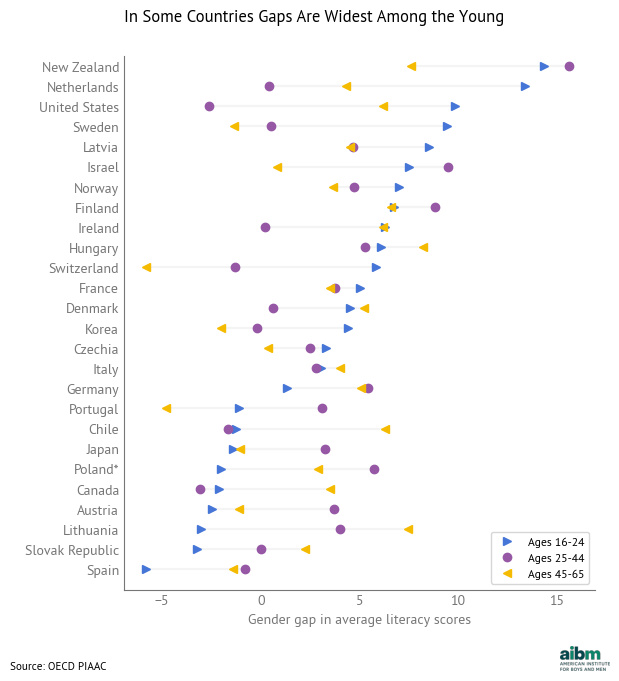

In [41]:
from utils import add_title, add_subtext, add_logo

diffs_sorted = diffs.sort_values(by='diff_1624', ascending=False)
country = diffs_sorted['country']
young = diffs_sorted['diff_1624']
middle = diffs_sorted['diff_2544']
old = diffs_sorted['diff_4565']

fig, ax = plt.subplots(figsize=(6, 6))
plt.hlines(country, young, middle, color=AIBM_COLORS['light_gray'])
plt.hlines(country, old, middle, color=AIBM_COLORS['light_gray'])

plt.plot(young, country, '>', 
         color=AIBM_COLORS['blue'], label='Ages 16-24')
plt.plot(middle, country, 'o', 
         color=AIBM_COLORS['purple'], label='Ages 25-44')
plt.plot(old, country, '<', 
         color=AIBM_COLORS['amber'], label='Ages 45-65')
ax.invert_yaxis()

decorate(xlabel='Gender gap in average literacy scores', ylim=[len(piaac2), 0.5])
add_title("In Some Countries Gaps Are Widest Among the Young",
          "", y=1.01)
add_subtext("Source: OECD PIAAC", y=-0.05)
logo = add_logo(location=(1.0, -0.05))

In some countries the gender gap is widest among young people.
In these countries, the use of a lagging indicator might understate the degree of inequality.

Not to make too much of this point -- it is probably a reasonable thing to include in the index one measure that is an aggregation of the entire population, along with snapshots of current education.

### Merge PIACC into WEF



In [42]:
merge_column(wef, piaac['score'], "piaac_score")

Index(['ALB', 'DZA', 'AGO', 'ARG', 'ARM', 'AUS', 'AZE', 'BHR', 'BGD', 'BRB',
       ...
       'UKR', 'ARE', 'GBR', 'TZA', 'URY', 'UZB', 'VUT', 'VNM', 'ZMB', 'ZWE'],
      dtype='object', name='code', length=119)

There are only a few countries where we have an UNESCO score and a PIACC score. Some countries that got perfect scores from WEF get downgraded based on PIACC, but not by much.

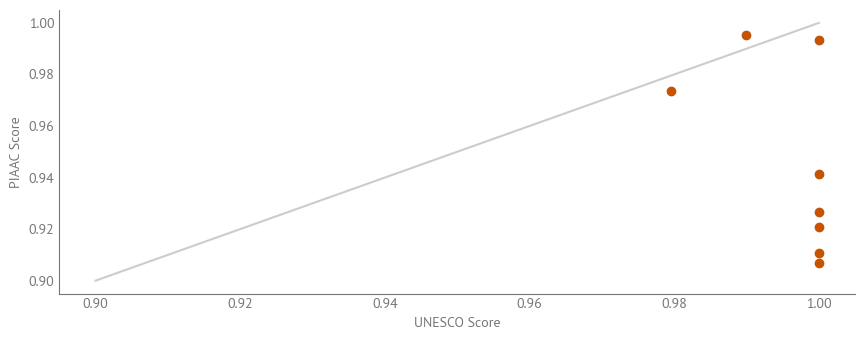

In [43]:
plt.plot([0.9, 1], [0.9, 1], color='gray', alpha=0.4)
plt.scatter(wef['unesco_score'], wef['piaac_score'])
decorate(xlabel='UNESCO Score', ylabel='PIAAC Score')

## Bring it together

Now let's bring in the data from OWID and PIACC.

In [44]:
wef['revised_score'] = wef['score'].where(wef['unesco_score'].isna(), 
                                          wef['unesco_score'])
wef['revised_score'].describe()

count    146.000000
mean       0.928523
std        0.118821
min        0.488889
25%        0.909091
50%        0.988088
75%        1.000000
max        1.000000
Name: revised_score, dtype: float64

In [45]:
wef['revised_score'] = wef['revised_score'].where(wef['piaac_score'].isna(), 
                                                  wef['piaac_score'])
wef['revised_score'].describe()

count    146.000000
mean       0.920544
std        0.115860
min        0.488889
25%        0.906158
50%        0.969223
75%        0.994905
max        1.000000
Name: revised_score, dtype: float64

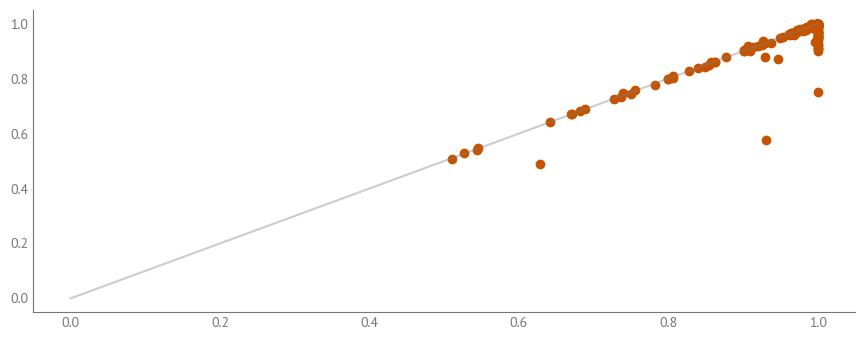

In [46]:
plt.plot([0, 1], [0, 1], color='gray', alpha=0.4)
plt.scatter(wef['score'], wef['revised_score'])
decorate()

In [47]:
wef['diff_score'] = np.abs(wef['revised_score'] - wef['score'])

In [48]:
wef.sort_values(by='diff_score', ascending=False).head(20)

,country,page_number,score,rank,unesco_score,unesco_score_truncated,piaac_score,revised_score,diff_score
code,,,,,,,,,
CIV,Côte D'Ivoire,153,0.931,103.0,0.576923,0.576923,NaN,0.576923,0.354077
LSO,Lesotho,237,1.000,1.0,0.750000,1.000000,NaN,0.750000,0.250000
BEN,Benin,111,0.629,140.0,0.488889,0.488889,NaN,0.488889,0.140111
NZL,New Zealand,275,1.000,1.0,NaN,NaN,0.900743,0.900743,0.099257
EST,Estonia,171,1.000,1.0,1.000000,1.000000,0.906984,0.906984,0.093016
HUN,Hungary,201,1.000,1.0,1.000000,1.000000,0.910796,0.910796,0.089204
ISR,Israel,213,1.000,1.0,NaN,NaN,0.911642,0.911642,0.088358
LVA,Latvia,233,1.000,1.0,1.000000,1.000000,0.920939,0.920939,0.079061
RWA,Rwanda,307,0.947,101.0,0.873239,0.873239,NaN,0.873239,0.073761


Here's the distribution of revised scores.

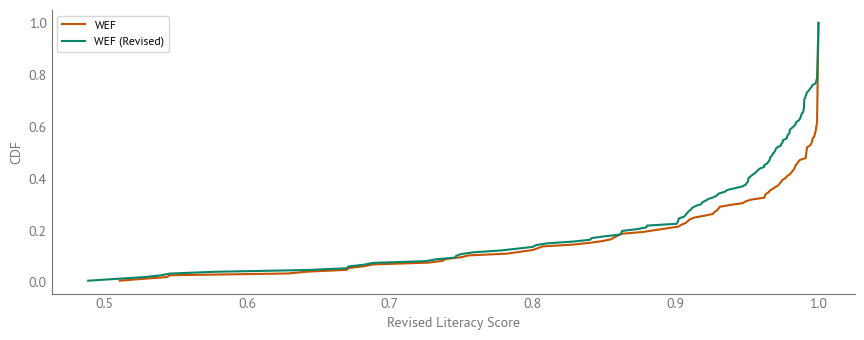

In [52]:
cdf_score = Cdf.from_seq(wef['score'])
cdf_score.plot(label='WEF')
cdf_revised = Cdf.from_seq(wef['revised_score'])
cdf_revised.plot(label='WEF (Revised)')
decorate(xlabel='Revised Literacy Score', ylabel='CDF')

In [53]:
wef_sorted = wef.sort_values(by='score', ascending=False)

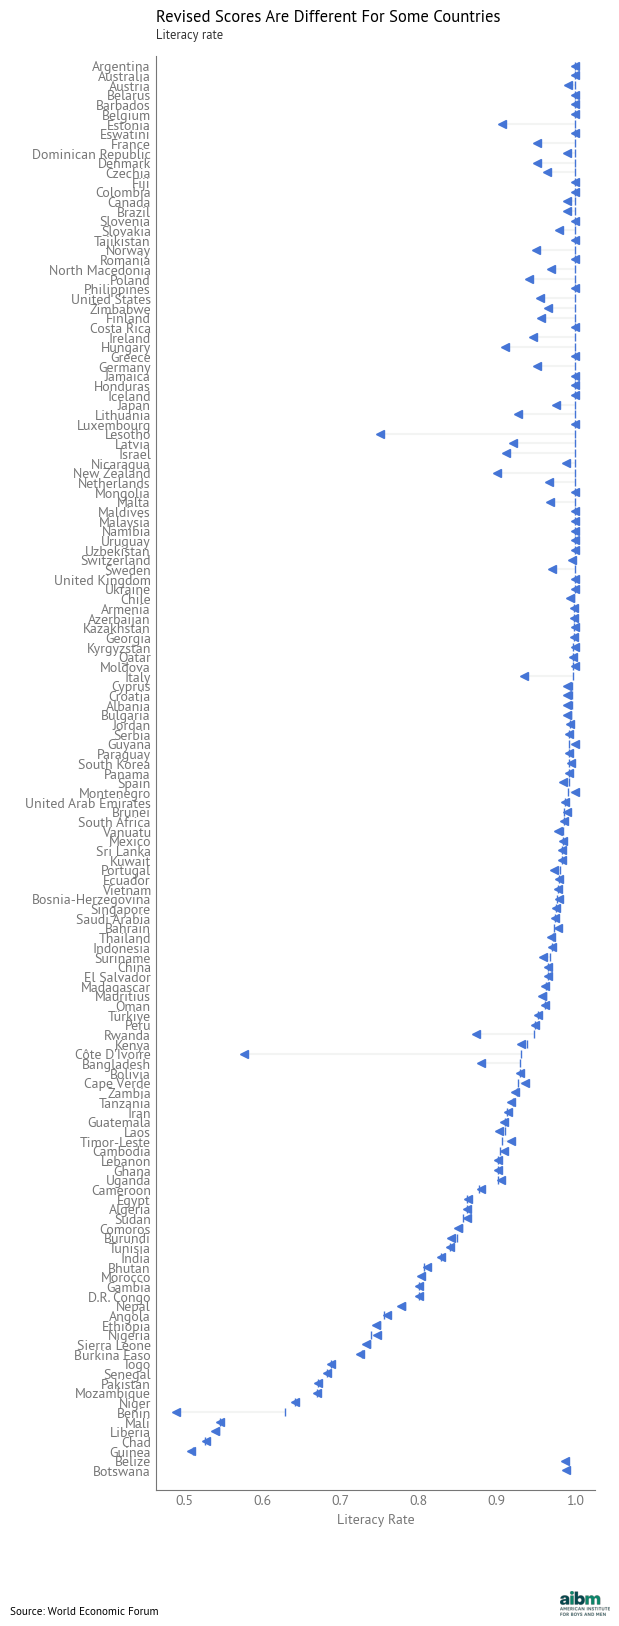

In [55]:
# make a figure that shows a horizontal line for each country that
# connects the revised score and the secondary enrolment score
# with a circle for the original and a triangle for the revised

from utils import add_title, add_subtext, add_logo

fig, ax = plt.subplots(figsize=(6, 15))
plt.hlines(wef_sorted['country'], 
           wef_sorted['score'], wef_sorted['revised_score'], 
           color=AIBM_COLORS['light_gray'])
plt.plot(wef_sorted['score'], wef_sorted['country'], '|', 
         color=AIBM_COLORS['blue'])
plt.plot(wef_sorted['revised_score'], wef_sorted['country'], '<', 
         color=AIBM_COLORS['blue'])
ax.invert_yaxis()

decorate(xlabel='Literacy Rate', ylim=[len(wef_sorted)+1, -1])
add_title("Revised Scores Are Different For Some Countries",
          "Literacy rate", y=1.01)
add_subtext("Source: World Economic Forum", y=-0.05)
logo = add_logo(location=(1.0, -0.05))



And here's the new ranking of countries based on revised scores.

In [57]:
columns = ['revised_rank', 'country', 'score', 'revised_score']
wef_sorted = wef.dropna(subset=['score']).sort_values(by='revised_score', ascending=False)
wef_sorted['revised_rank'] = np.arange(1, len(wef_sorted)+1)
table = wef_sorted[columns].round(2)
table.to_csv("wef_literacy_rate_table.csv", index=False)

In [58]:
wef_sorted[columns].head(40).round(2)

,revised_rank,country,score,revised_score
code,,,,
ARG,1,Argentina,1.00,1.00
AUS,2,Australia,1.00,1.00
BRB,3,Barbados,1.00,1.00
BLR,4,Belarus,1.00,1.00
BEL,5,Belgium,1.00,1.00
KGZ,6,Kyrgyzstan,1.00,1.00
KAZ,7,Kazakhstan,1.00,1.00
JAM,8,Jamaica,1.00,1.00
GUY,9,Guyana,0.99,1.00


In [59]:
wef_sorted[columns].tail(50).round(2)

,revised_rank,country,score,revised_score
code,,,,
KEN,95,Kenya,0.94,0.93
BOL,96,Bolivia,0.93,0.93
LTU,97,Lithuania,1.00,0.93
ZMB,98,Zambia,0.93,0.92
LVA,99,Latvia,1.00,0.92
TZA,100,Tanzania,0.92,0.92
TLS,101,Timor-Leste,0.91,0.92
IRN,102,Iran,0.91,0.91
ISR,103,Israel,1.00,0.91


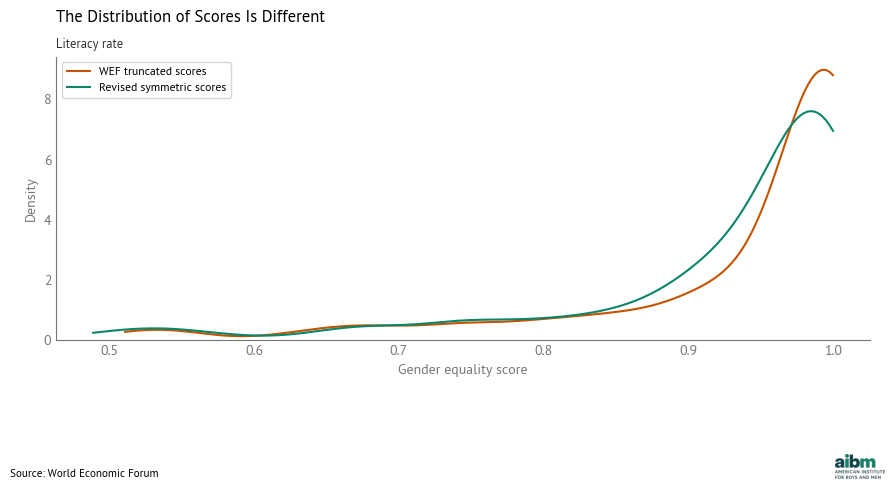

In [61]:
import seaborn as sns

options = dict(cut=0, bw_adjust=0.7)

sns.kdeplot(wef['score'], label='WEF truncated scores', **options)
sns.kdeplot(wef['revised_score'], label='Revised symmetric scores', **options)

decorate(xlabel='Gender equality score')

add_title("The Distribution of Scores Is Different",
          "Literacy rate")
add_subtext("Source: World Economic Forum", y=-0.25)
logo = add_logo(location=(1.0, -0.25))
None